# RESIT

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

import warnings
warnings.filterwarnings('ignore')

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)

['1.21.5', '1.3.2', '0.17', '1.6.0']


## Test data
First, we generate a causal structure with 7 variables. Then we create a dataset with 6 variables from x0 to x5, with x6 being the latent variable for x2 and x3.

In [2]:
X = pd.read_csv('nonlinear_data.csv')

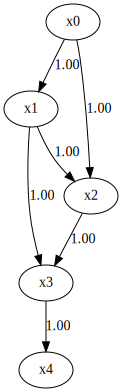

In [3]:
m = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 1, 1, 0, 0],
    [0, 0, 0, 1, 0]])

dot = make_dot(m)

# Save pdf
dot.render('dag')

# Save png
dot.format = 'png'
dot.render('dag')

dot

## Causal Discovery
To run causal discovery, we create a `RESIT` object and call the `fit` method.

In [4]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(max_depth=4, random_state=0)

model = lingam.RESIT(regressor=reg)
model.fit(X)

Using the `causal_order_` properties, we can see the causal ordering as a result of the causal discovery. x2 and x3, which have latent confounders as parents, are stored in a list without causal ordering.

In [5]:
model.causal_order_

[0, 1, 2, 3, 4]

Also, using the `adjacency_matrix_` properties, we can see the adjacency matrix as a result of the causal discovery. The coefficients between variables with latent confounders are np.nan.

In [6]:
model.adjacency_matrix_

array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

We can draw a causal graph by utility funciton.

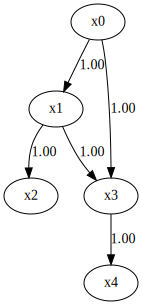

In [7]:
make_dot(model.adjacency_matrix_)

## Bootstrapping
We call `bootstrap()` method instead of `fit()`. Here, the second argument specifies the number of bootstrap sampling.

In [8]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

n_sampling = 100
model = lingam.RESIT(regressor=reg)
result = model.bootstrap(X, n_sampling=n_sampling)

## Causal Directions
Since `BootstrapResult` object is returned, we can get the ranking of the causal directions extracted by `get_causal_direction_counts()` method. In the following sample code, `n_directions` option is limited to the causal directions of the top 8 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.01 or more.

In [9]:
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [10]:
print_causal_directions(cdc, n_sampling)

x1 <--- x0 (b>0) (100.0%)
x2 <--- x1 (b>0) (71.0%)
x4 <--- x1 (b>0) (62.0%)
x2 <--- x0 (b>0) (62.0%)
x3 <--- x1 (b>0) (53.0%)
x3 <--- x4 (b>0) (52.0%)
x4 <--- x3 (b>0) (47.0%)
x3 <--- x0 (b>0) (44.0%)


## Directed Acyclic Graphs
Also, using the `get_directed_acyclic_graph_counts()` method, we can get the ranking of the DAGs extracted. In the following sample code, `n_dags` option is limited to the dags of the top 3 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.01 or more.

In [11]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [12]:
print_dagc(dagc, n_sampling)

DAG[0]: 13.0%
	x1 <--- x0 (b>0)
	x2 <--- x1 (b>0)
	x3 <--- x4 (b>0)
	x4 <--- x0 (b>0)
	x4 <--- x1 (b>0)
DAG[1]: 13.0%
	x1 <--- x0 (b>0)
	x2 <--- x0 (b>0)
	x2 <--- x1 (b>0)
	x3 <--- x4 (b>0)
	x4 <--- x1 (b>0)
DAG[2]: 11.0%
	x1 <--- x0 (b>0)
	x2 <--- x1 (b>0)
	x3 <--- x0 (b>0)
	x3 <--- x1 (b>0)
	x4 <--- x3 (b>0)


## Probability
Using the `get_probabilities()` method, we can get the probability of bootstrapping.

In [13]:
prob = result.get_probabilities(min_causal_effect=0.01)
print(prob)

[[0.   0.   0.   0.02 0.  ]
 [1.   0.   0.07 0.05 0.01]
 [0.62 0.71 0.   0.06 0.03]
 [0.44 0.53 0.18 0.   0.52]
 [0.43 0.62 0.21 0.47 0.  ]]


## Bootstrap Probability of Path
Using the `get_paths()` method, we can explore all paths from any variable to any variable and calculate the bootstrap probability for each path. The path will be output as an array of variable indices. For example, the array `[0, 1, 3]` shows the path from variable X0 through variable X1 to variable X3.

In [14]:
from_index = 0 # index of x0
to_index = 3 # index of x3

pd.DataFrame(result.get_paths(from_index, to_index))

,path,effect,probability
0,"[0, 1, 3]",1.0,0.53
1,"[0, 1, 4, 3]",1.0,0.51
2,"[0, 3]",1.0,0.44
3,"[0, 4, 3]",1.0,0.33
4,"[0, 2, 3]",1.0,0.12
5,"[0, 1, 2, 3]",1.0,0.11
6,"[0, 2, 4, 3]",1.0,0.07
7,"[0, 1, 2, 4, 3]",1.0,0.04
8,"[0, 1, 4, 2, 3]",1.0,0.03
9,"[0, 2, 1, 3]",1.0,0.01
